# Beetaloo: MICE (max_iter=10), 
# Sensitivity Analysis Random Forest

In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import KFold, GroupKFold

from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


## 1. Data Pre-processing

In [2]:
# beetaloo dataset
beetaloo = pd.read_csv(filepath_or_buffer='dataset_beetaloo.csv', low_memory=False)
beetaloo.head()

,WELL_ID,YEAR,LATITUDE,LONGITUDE,DEPTH,DENSITY,GR,SONIC,RESISTIVITY,SP,NEUTRON,CALIPER,BITSIZE,TOC_CORE,TOC_CUTTINGS,LITHO,ORDER_3,ORDER_4
0,Alexander_1,1988.0,-15.16911,134.855921,63.1,NaN,111.753,NaN,NaN,NaN,NaN,4.705,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
1,Alexander_1,1988.0,-15.16911,134.855921,63.2,NaN,108.300,NaN,NaN,NaN,NaN,4.701,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
2,Alexander_1,1988.0,-15.16911,134.855921,63.3,NaN,105.699,NaN,NaN,NaN,NaN,4.676,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
3,Alexander_1,1988.0,-15.16911,134.855921,63.4,NaN,106.119,NaN,NaN,NaN,NaN,4.668,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5
4,Alexander_1,1988.0,-15.16911,134.855921,63.5,NaN,106.734,NaN,NaN,NaN,NaN,4.691,NaN,NaN,NaN,Velkerri Formation,HST-2,RST-2.5


In [3]:
# rename columns
beetaloo.rename(columns={'LONGITUDE': 'X',
                         'LATITUDE' : 'Y',
                         'DENSITY': 'RHOB', 
                         'SONIC': 'DT',
                         'RESISTIVITY': 'RES', 
                         'NEUTRON': 'NPHI',
                         'ORDER_4': 'STRAT'
                        }, inplace=True
               )

In [4]:
# complete the location of some wells
wells_no_location = ['Balmain_1', 'Birdum_Creek_1', 'Broadmere_1', 'Jamison_1', 'Lady_Penrhyn_1', 'Marmbulligan_1', 'Ronald_1', 'Scarborough_1', 'Sever_1', 'Tarlee_1', 'Walton_2', 'Wyworrie_1']

x_coord = [-92402.40724, 142017.0021, -24907.23409, -501.9841485, 82970.28312, 17486.61935, 86665.76837, -125242.803, -124956.7945, -38322.74503, -135702.1635]
y_coord = [-1809383.515, -1887528.408, -1936401.136, -1747313.691, -1872700.38, -1877801.953, -1759280.809, -1766817.469, -1845740.884, -1839970.706, -1780656.283]

lat = [-16.620444] 
lon = [133.577361]



# convert GDA94 to WGS84
import pyproj
# GDA94 / Geoscience Australia Lambert, EPSG:3112
# WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS, EPSG:4326
gda94_wgs84 = pyproj.Transformer.from_crs(3112, 4326)
for i in range(len(x_coord)):
    new_coord = gda94_wgs84.transform(x_coord[i], y_coord[i])
    lat.append(new_coord[0])
    lon.append(new_coord[1])

# replace coordinates in the dataset
for i in range(len(wells_no_location)):
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LATITUDE'] = lat[i]
    beetaloo.loc[beetaloo['WELL_ID'] == wells_no_location[i], 'LONGITUDE'] = lon[i]

In [5]:
# drop unnecessary columns
beetaloo.drop(['YEAR', 'CALIPER', 'BITSIZE', 'TOC_CORE', 'TOC_CUTTINGS', 'ORDER_3'], axis=1, inplace=True)

In [6]:
# handle outliers and well-log transformation

# replace sonic values smaller than 0 for NaN values
mask = beetaloo['DT'] < 0
beetaloo.loc[mask, 'DT'] = np.nan

# replace resistivity values smaller than or equal to 0 for NaN values
mask = beetaloo['RES'] <= 0
beetaloo.loc[mask, 'RES'] = np.nan

# create a new column to store log base 10 of resistivity
beetaloo['RES_10'] = np.log10(beetaloo['RES']+1)

# replace neutron porosity values smaller than 0 for NaN values
mask = beetaloo['NPHI'] < 0
beetaloo.loc[mask, 'NPHI'] = np.nan

# convert percentage to fraction
def convert_neutron(x):
    if x >= 1:
        return x / 100
    else:
        return x

beetaloo['NPHI'] = beetaloo['NPHI'].apply(convert_neutron)

In [7]:
well_logs = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

In [8]:
# label encoding for well id
well_encoder = LabelEncoder()
beetaloo['WELL'] = well_encoder.fit_transform(beetaloo['WELL_ID'])

# label encoding for stratigraphy
strat_encoder = LabelEncoder()
beetaloo['STRAT_ENCODED'] = strat_encoder.fit_transform(beetaloo['STRAT'])

In [9]:
# columns
beetaloo.columns

Index(['WELL_ID', 'Y', 'X', 'DEPTH', 'RHOB', 'GR', 'DT', 'RES', 'SP', 'NPHI',
       'LITHO', 'STRAT', 'LATITUDE', 'LONGITUDE', 'RES_10', 'WELL',
       'STRAT_ENCODED'],
      dtype='object')

In [10]:
# feature selection
selected_features = ['WELL', 'X', 'Y', 'DEPTH', 
                     'RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI',
                     'STRAT_ENCODED']

## 2. Data Splitting

In [11]:
# copy of the dataset for modeling
data_ml = beetaloo[selected_features].copy()

In [12]:
# well test selection
test_wells = well_encoder.transform(['Tarlee_2', 'Beetaloo_W1', 'Friendship_1', 'Burdo_1', 'McManus_1', 'Amungee_NW1'])

# mask for test well
test_mask = data_ml['WELL'].isin(test_wells)

# column to identify train and test wells
data_ml['train_test'] = 'Train'
data_ml.loc[test_mask, 'train_test'] = 'Test'

# fraction of data
train_fraction = data_ml[data_ml['train_test'] == 'Train'].shape[0] / data_ml.shape[0]
test_fraction = data_ml[data_ml['train_test'] == 'Test'].shape[0] / data_ml.shape[0]
print(f"Fraction of data in train set: {train_fraction:.2f}")
print(f"Fraction of data in test set: {test_fraction:.2f}")
print(f"Total number of samples in dataset: {data_ml.shape[0]}")

Fraction of data in train set: 0.83
Fraction of data in test set: 0.17
Total number of samples in dataset: 352143


In [13]:
# create train and test sets
train = data_ml[~test_mask].copy()
test = data_ml[test_mask].copy()

## 3. Model Training

### 3.1. Input Values

In [14]:
# copy of train and test sets
X_train = train.copy()
X_test = test.copy()

In [15]:
# features to impute 
features_mice = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI', 'STRAT_ENCODED']
imputed_cols = ['RHOB', 'GR', 'DT', 'RES_10', 'SP', 'NPHI']

In [16]:
# list with all combinations of well-logs for each well
unique_wells = X_train['WELL'].unique()
combinations = []
for well in unique_wells:
    for feature in imputed_cols:
        # only for well-logs that are not completely NaN
        if not X_train.loc[X_train['WELL'] == well, feature].isna().all():
            combinations.append((well, feature))
            
print('Number of Combinations:', len(combinations))

Number of Combinations: 119


In [17]:
# function to impute NaN values using iterative imputer (MICE)
def impute(train_data, cols_imp, model):
    mice = IterativeImputer(estimator=model, initial_strategy='mean' , random_state=17, max_iter=10, tol=0.01)
    mice.fit(train_data[cols_imp])
    imputed_train = mice.transform(train_data[cols_imp])
    return imputed_train, mice

### 3.2. Hyperparameter Tuning

In [18]:
def tuning_cv(X_train, model, param_grid, well_logs, cols_imp, combinations, n_splits, n_jobs):
    """
    Cross-Validation for Hyperparameter Tuning using MICE
    
    Parameters
    -------------------------------------------------------------------------------------------
        X_train: (pd.DataFrame) 
            Training data
        
        model: (model object for imputation)
            Model (e.g., KNeighborsRegressor, BayesianRidge, RF, XGBoost)
            
        param_grid: (dict)
            Dictionary of hyperparameter grids for the model
            
        well_logs: (list)
            List of well logs to evaluate
            
        cols_imp: (list)
            List of columns to impute
            
        combinations: (list)
            List of well and feature combinations
            
        n_splits: (int)
            Number of cross-validation splits
            
        n_jobs: (int)
            Number of jobs to run in parallel during imputation
    
    Returns
    -------------------------------------------------------------------------------------------
        results_df: (pd.DataFrame)
            DataFrame containing the evaluation results
            
        final_time: (float)
            Execution time in seconds
    """   
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    
    results = {}
    
    start_time = time.time()  
    
    for params in ParameterGrid(param_grid):
        for i, (train_index, val_index) in enumerate(kf.split(combinations)):
            
            # train and validations sets
            train_combinations = [combinations[i] for i in train_index]
            validation_combinations = [combinations[i] for i in val_index]
            
            # copy of the data to work with
            data_train = X_train.copy()
            
            # set values to NaN in the data to impute using the validation combinations
            for well_id, feature_name in validation_combinations:
                data_train.loc[data_train['WELL']==well_id, feature_name] = np.nan
                
                
            # scale the data for training with NaN 
            scaler = MinMaxScaler()
            scaler.fit(data_train[cols_imp])
            X_training_scaled = scaler.transform(data_train[cols_imp])
            X_training_scaled_df = pd.DataFrame(X_training_scaled, 
                                                columns=cols_imp,
                                                index=X_train.index)
            
            # scale the orignal training data
            X_training_original_scale = scaler.transform(X_train[cols_imp])        
            X_training_original_df = pd.DataFrame(X_training_original_scale, 
                                                  columns=cols_imp,
                                                  index=X_train.index)
            X_training_original_df['WELL'] = X_train['WELL']
                
            # impute NaN values using iterative imputer
            if model == KNeighborsRegressor:
                X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                                   cols_imp=cols_imp,
                                                   model=model(**params, n_jobs=n_jobs))
                
            elif model == BayesianRidge:
                X_training_imp, imp_model = impute(train_data=X_training_scaled_df,
                                                   cols_imp=cols_imp,
                                                   model=model(**params))
                
            else:
                X_training_imp, imp_model = impute(train_data= X_training_scaled_df,  
                                                   cols_imp=cols_imp,
                                                   model=model(**params, random_state=17, n_jobs=n_jobs))


            X_training_imp_scaled = pd.DataFrame(X_training_imp, columns=cols_imp, index=X_train.index)
            
            
            # evaluate the imputation using validation combinations
            mse_results = {col: [] for col in well_logs}
            
            for well_id, feature_name in validation_combinations:
                original = X_training_original_df.loc[X_training_original_df['WELL']==well_id, feature_name].dropna()
                original_index = list(original.index.values)
                
                imputed = X_training_imp_scaled.loc[original_index, feature_name]
                
                mse = mean_squared_error(original, imputed)
                mse_results[feature_name].append(mse)

            mean_mse = {col: np.mean(mse_results[col]) for col in mse_results}
             
            param_name = tuple(f"{k}={v}" for k, v in params.items())
            for col in well_logs:
                key = (param_name, col)
                results[key] = {'MSE': mean_mse[col]}
    
    # final results
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'level_0': 'PARAMETERS', 'level_1': 'WELL_LOGS'})
    
    
    end_time = time.time()  # record end time
    final_time = end_time - start_time  # final time
    
    return results_df, final_time

In [19]:
def print_tuning_results(time_print, df_result_print, top_n=10):

    print('Tuning Time: {:.2f} seconds\n'.format(time_print))
    
    top_results = df_result_print.groupby('PARAMETERS')['MSE'].mean().sort_values().head(top_n)
    print('Top MSE Results:')
    
    for tuning_parameter, tuning_mse_result in top_results.items():
        print('MSE: {:.4f}, Parameters: {}'.format(tuning_mse_result, tuning_parameter))
        

#### 1. max_depth [default=None]

In [20]:
param_grid_rf = {'max_depth': [1, 6, 10, 15]}

In [21]:
results_rf, time_rf = tuning_cv(X_train=X_train,
                                model=RandomForestRegressor, 
                                param_grid=param_grid_rf,
                                well_logs=imputed_cols,
                                cols_imp=features_mice, 
                                combinations=combinations, 
                                n_splits=5,
                                n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [22]:
print_tuning_results(time_rf, results_rf, top_n=10)

Tuning Time: 7956.79 seconds

Top MSE Results:
MSE: 0.0126, Parameters: ('max_depth=10',)
MSE: 0.0140, Parameters: ('max_depth=15',)
MSE: 0.0154, Parameters: ('max_depth=6',)
MSE: 0.0275, Parameters: ('max_depth=1',)


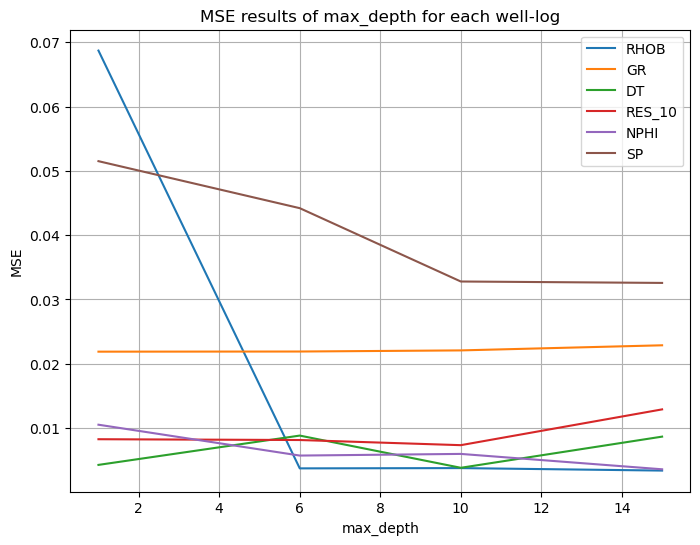

In [23]:
df_tuning_plot = results_rf
cols = ['RHOB', 'GR', 'DT', 'RES_10', 'NPHI', 'SP']
name_param = 'max_depth'

fig, ax = plt.subplots(figsize=(8, 6))

for well_log in cols:
    data = df_tuning_plot[df_tuning_plot['WELL_LOGS'] == well_log]
    params = data['PARAMETERS'].apply(lambda x: int(x[0].split('=')[1]))
    mse_scores = data['MSE']
    sorted_indices = params.argsort()
    params = params.iloc[sorted_indices]
    mse_scores = mse_scores.iloc[sorted_indices]
    ax.plot(params, mse_scores, label=well_log)

ax.legend()
ax.grid(True)
ax.set_title(f'MSE results of {name_param} for each well-log')
ax.set_xlabel(f'{name_param}')
ax.set_ylabel('MSE')

plt.show()

#### 2. n_estimators [default=100]

In [24]:
param_grid_rf2 = {'max_depth': [10],  
                  'n_estimators': [1, 10, 50, 100, 200]
                 } 

In [25]:
results_rf2, time_rf2 = tuning_cv(X_train=X_train,
                                  model=RandomForestRegressor, 
                                  param_grid=param_grid_rf2,
                                  well_logs=imputed_cols,
                                  cols_imp=features_mice, 
                                  combinations=combinations, 
                                  n_splits=5,
                                  n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [26]:
print_tuning_results(time_rf2, results_rf2, top_n=5)

Tuning Time: 8941.15 seconds

Top MSE Results:
MSE: 0.0125, Parameters: ('max_depth=10', 'n_estimators=10')
MSE: 0.0126, Parameters: ('max_depth=10', 'n_estimators=100')
MSE: 0.0131, Parameters: ('max_depth=10', 'n_estimators=200')
MSE: 0.0145, Parameters: ('max_depth=10', 'n_estimators=1')
MSE: 0.0153, Parameters: ('max_depth=10', 'n_estimators=50')


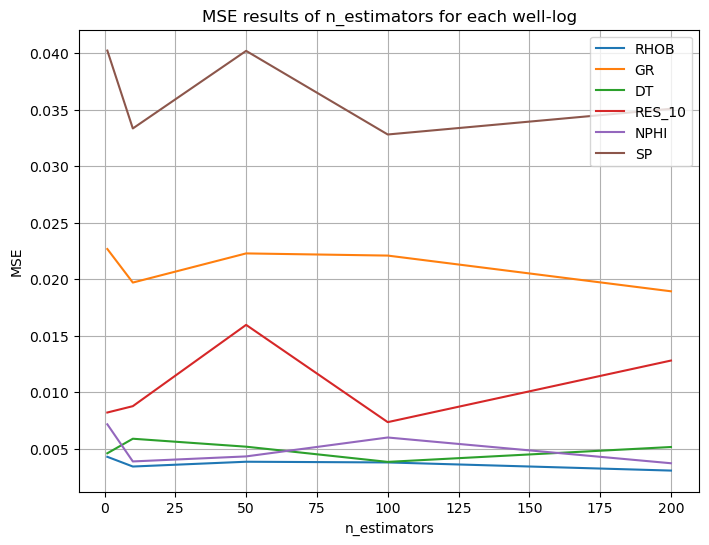

In [27]:
df_tuning_plot = results_rf2
cols = ['RHOB', 'GR', 'DT', 'RES_10', 'NPHI', 'SP']
name_param = 'n_estimators'

fig, ax = plt.subplots(figsize=(8, 6))

for well_log in cols:
    data = df_tuning_plot[df_tuning_plot['WELL_LOGS'] == well_log]
    params = data['PARAMETERS'].apply(lambda x: int(x[1].split('=')[1].strip(')')))
    mse_scores = data['MSE']
    sorted_indices = params.argsort()
    params = params.iloc[sorted_indices]
    mse_scores = mse_scores.iloc[sorted_indices]
    ax.plot(params, mse_scores, label=well_log)

ax.legend()
ax.grid(True)
ax.set_title(f'MSE results of {name_param} for each well-log')
ax.set_xlabel(f'{name_param}')
ax.set_ylabel('MSE')

plt.show()

#### 3. min_samples_split [default=2]

In [28]:
param_grid_rf3 = {'max_depth': [10],
                 'min_samples_split': [2, 6, 10, 15]
                 } 

In [29]:
results_rf3, time_rf3 = tuning_cv(X_train=X_train,
                                  model=RandomForestRegressor, 
                                  param_grid=param_grid_rf3,
                                  well_logs=imputed_cols,
                                  cols_imp=features_mice, 
                                  combinations=combinations, 
                                  n_splits=5,
                                  n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [30]:
print_tuning_results(time_rf3, results_rf3, top_n=5)

Tuning Time: 9393.63 seconds

Top MSE Results:
MSE: 0.0126, Parameters: ('max_depth=10', 'min_samples_split=10')
MSE: 0.0126, Parameters: ('max_depth=10', 'min_samples_split=2')
MSE: 0.0134, Parameters: ('max_depth=10', 'min_samples_split=6')
MSE: 0.0138, Parameters: ('max_depth=10', 'min_samples_split=15')


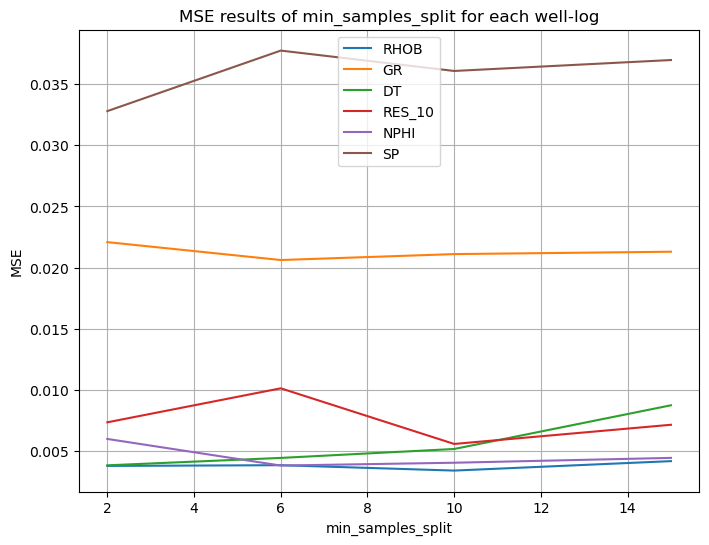

In [31]:
df_tuning_plot = results_rf3
cols = ['RHOB', 'GR', 'DT', 'RES_10', 'NPHI', 'SP']
name_param = 'min_samples_split'

fig, ax = plt.subplots(figsize=(8, 6))

for well_log in cols:
    data = df_tuning_plot[df_tuning_plot['WELL_LOGS'] == well_log]
    params = data['PARAMETERS'].apply(lambda x: int(x[1].split('=')[1].strip(')')))
    mse_scores = data['MSE']
    sorted_indices = params.argsort()
    params = params.iloc[sorted_indices]
    mse_scores = mse_scores.iloc[sorted_indices]
    ax.plot(params, mse_scores, label=well_log)

ax.legend()
ax.grid(True)
ax.set_title(f'MSE results of {name_param} for each well-log')
ax.set_xlabel(f'{name_param}')
ax.set_ylabel('MSE')

plt.show()


#### 4. min_samples_leaf [default=1]

In [32]:
param_grid_rf4 = {'max_depth': [10],
                  'min_samples_leaf': [1, 5, 10, 15]
                 }

In [33]:
results_rf4, time_rf4 = tuning_cv(X_train=X_train,
                                  model=RandomForestRegressor, 
                                  param_grid=param_grid_rf4,
                                  well_logs=imputed_cols,
                                  cols_imp=features_mice, 
                                  combinations=combinations, 
                                  n_splits=5,
                                  n_jobs=-1)

C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lcbae\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\lcbae\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

In [34]:
print_tuning_results(time_rf4, results_rf4, top_n=5)

Tuning Time: 9326.35 seconds

Top MSE Results:
MSE: 0.0126, Parameters: ('max_depth=10', 'min_samples_leaf=1')
MSE: 0.0131, Parameters: ('max_depth=10', 'min_samples_leaf=10')
MSE: 0.0131, Parameters: ('max_depth=10', 'min_samples_leaf=5')
MSE: 0.0140, Parameters: ('max_depth=10', 'min_samples_leaf=15')


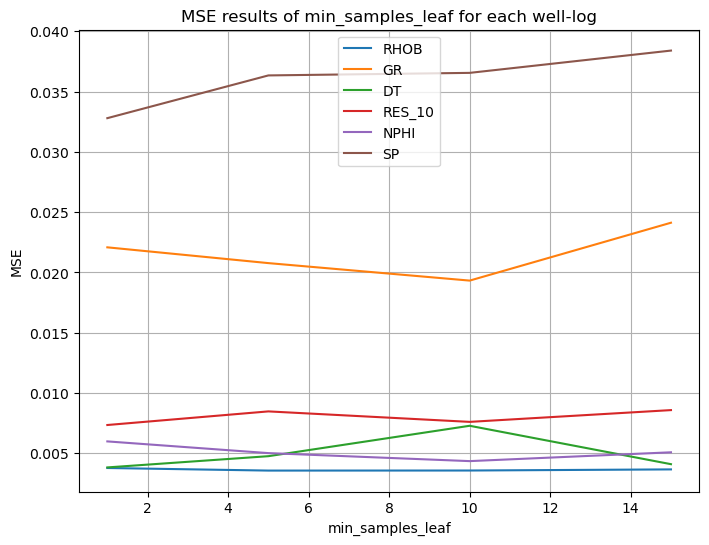

In [35]:
df_tuning_plot = results_rf4
cols = ['RHOB', 'GR', 'DT', 'RES_10', 'NPHI', 'SP']
name_param = 'min_samples_leaf'

fig, ax = plt.subplots(figsize=(8, 6))

for well_log in cols:
    data = df_tuning_plot[df_tuning_plot['WELL_LOGS'] == well_log]
    params = data['PARAMETERS'].apply(lambda x: int(x[1].split('=')[1].strip(')')))
    mse_scores = data['MSE']
    sorted_indices = params.argsort()
    params = params.iloc[sorted_indices]
    mse_scores = mse_scores.iloc[sorted_indices]
    ax.plot(params, mse_scores, label=well_log)

ax.legend()
ax.grid(True)
ax.set_title(f'MSE results of {name_param} for each well-log')
ax.set_xlabel(f'{name_param}')
ax.set_ylabel('MSE')

plt.show()